In [1]:
import scipy.sparse as sp
import scipy.sparse.csgraph as csgraph
import numpy as np
import time
import pickle
import random
import matplotlib.pyplot as plt
import networkx as nx
import argparse
import random
import pandas as pd
import networkx as nx
import scipy
import glob
import itertools
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [11]:
# Load 
def load_data(target: str):
    results_df_all = pd.DataFrame(columns=['iteration', 'cascade', 'edges_added', 'state_init', 'tuple'])

    datasets = [
    'simulation_results/results_fb_snap',
    'simulation_results/results_fb_mich',
    'simulation_results/results_fb_wel'
    ]

    if target == 'fb':
        path = datasets[0]
    elif target == 'mich':
        path = datasets[1]
    elif target == 'wel':
        path = datasets[2]

    for file in glob.glob(path + "/*.csv"):
        # Create a dataframe 
        results_df = pd.DataFrame(columns=['iteration', 'cascade', 'edges_added', 'state_init', 'tuple'])

        # Get the run details
        iteration = int(file.split('_')[7])
        state_init = file.split('_')[6]
        cascade = file.split('_')[8] == 'cascade.csv'
        edges_added = int(file.split('_')[5])
        
        run_df = pd.read_csv(file)

        # Convert run_df to a tuple
        I_state_counts = []
        A_state_counts = []
        S_state_counts = []
        R_state_counts = []
        polarization_external = []
        polarization_internal = []
        polarization_equilibrium = []
        disagreement_external = []
        disagreement_internal = []
        disagreement_equilibrium = []

        for i in range(len(run_df)):
            I_state_counts.append(run_df['I_state_counts,'][i])
            A_state_counts.append(run_df['A_state_counts,'][i])
            S_state_counts.append(run_df['S_state_counts,'][i])
            R_state_counts.append(run_df['R_state_counts,'][i])
            polarization_external.append(run_df['polarization_internal'][i])
            polarization_internal.append(run_df['polarization_external'][i])
            polarization_equilibrium.append(run_df['polarization_equilibrium'][i])
            disagreement_external.append(run_df['disagreement_internal'][i])
            disagreement_internal.append(run_df['disagreement_external'][i])
            disagreement_equilibrium.append(run_df['disagreement_equilibrium'][i])

        sim_tuple = (I_state_counts, A_state_counts, S_state_counts, R_state_counts, polarization_external, polarization_internal, polarization_equilibrium, disagreement_external, disagreement_internal, disagreement_equilibrium)

        # Add row to dataframe
        results_df.loc[0] = [iteration, cascade, edges_added, state_init, sim_tuple]

        results_df_all = pd.concat([results_df_all, results_df])
    print(len(results_df_all))
    return results_df_all

results_df_all_snap = load_data("fb")
results_df_all_wel = load_data("mich")
results_df_all_mich = load_data("wel")
print(results_df_all_snap.head())

120
120
120
  iteration cascade edges_added state_init  \
0         0    True           0  maxDegree   
0         0   False           0  maxDegree   
0         1    True           0  maxDegree   
0         1   False           0  maxDegree   
0         2    True           0  maxDegree   

                                               tuple  
0  ([4018.0, 3615.0, 1882.0, 493.0, 117.0, 66.0, ...  
0  ([4018.0, 4018.0, 4018.0, 4018.0, 4018.0, 4018...  
0  ([4018.0, 3577.0, 1377.0, 425.0, 112.0, 63.0, ...  
0  ([4018.0, 4018.0, 4018.0, 4018.0, 4018.0, 4018...  
0  ([4018.0, 3651.0, 1478.0, 321.0, 108.0, 70.0, ...  


In [12]:
# Average over iterations
def average_iterations(results_df_all):
    # Create a set of tuples to run
    state_init = ['random', 'maxDegree'] # 
    d_edges = [0, 2, 4, 8, 16, 32] #, 2, 4, 8, 12, 16, 24, 32, 48, 64
    # iterations = [0, 1, 2, 3, 4] # 
    cascade = ['cascade', 'noCascade']
    target_simulations = list(itertools.product(d_edges, cascade, state_init))

    results_df = pd.DataFrame(columns=['cascade', 'edges_added', 'state_init', 'tuple'])

    for sim in target_simulations:
        # Get the run details
        edges_added = sim[0]
        cascade = sim[1] == 'cascade'
        state_init = sim[2]
        
        # Filter dataframe
        results_df_sim = results_df_all[(results_df_all['edges_added'] == edges_added) & (results_df_all['cascade'] == cascade) & (results_df_all['state_init'] == state_init)]

        # Get tuples for each iteration
        sim_tuples = []
        for i in range(len(results_df_sim)):
            sim_tuples.append(results_df_sim['tuple'].iloc[i])
        
        # Average over iterations to create new tuple
        I_state_counts = []
        A_state_counts = []
        S_state_counts = []
        R_state_counts = []
        polarization_external = []
        polarization_internal = []
        polarization_equilibrium = []
        disagreement_external = []
        disagreement_internal = []
        disagreement_equilibrium = []

        for i in range(len(sim_tuples[0][0])):
            I_state_counts.append(np.mean([sim_tuples[j][0][i] for j in range(len(sim_tuples))]))
            A_state_counts.append(np.mean([sim_tuples[j][1][i] for j in range(len(sim_tuples))]))
            S_state_counts.append(np.mean([sim_tuples[j][2][i] for j in range(len(sim_tuples))]))
            R_state_counts.append(np.mean([sim_tuples[j][3][i] for j in range(len(sim_tuples))]))
            polarization_external.append(np.mean([sim_tuples[j][4][i] for j in range(len(sim_tuples))]))
            polarization_internal.append(np.mean([sim_tuples[j][5][i] for j in range(len(sim_tuples))]))
            polarization_equilibrium.append(np.mean([sim_tuples[j][6][i] for j in range(len(sim_tuples))]))
            disagreement_external.append(np.mean([sim_tuples[j][7][i] for j in range(len(sim_tuples))]))
            disagreement_internal.append(np.mean([sim_tuples[j][8][i] for j in range(len(sim_tuples))]))
            disagreement_equilibrium.append(np.mean([sim_tuples[j][9][i] for j in range(len(sim_tuples))]))
        
        sim_tuple = (I_state_counts, A_state_counts, S_state_counts, R_state_counts, polarization_external, polarization_internal, polarization_equilibrium, disagreement_external, disagreement_internal, disagreement_equilibrium)

        # Add row to dataframe
        results_df = results_df.append({'cascade': cascade, 'edges_added': edges_added, 'state_init': state_init, 'tuple': sim_tuple}, ignore_index=True)
    print(len(results_df))
    return results_df

results_df_snap = average_iterations(results_df_all_snap)
results_df_wel = average_iterations(results_df_all_wel)
results_df_mich = average_iterations(results_df_all_mich)

24
24
24


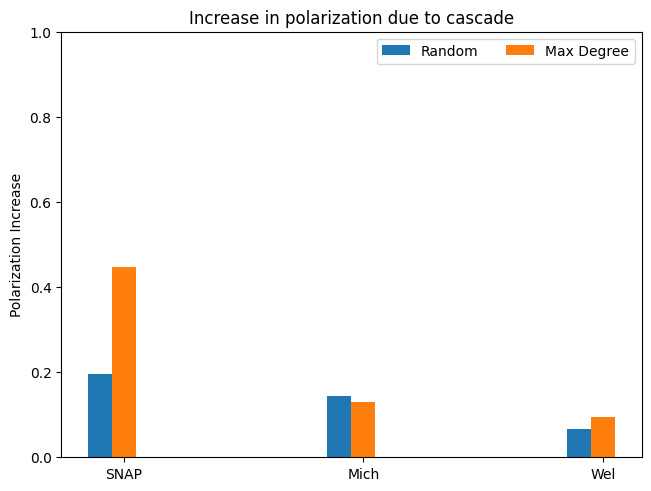

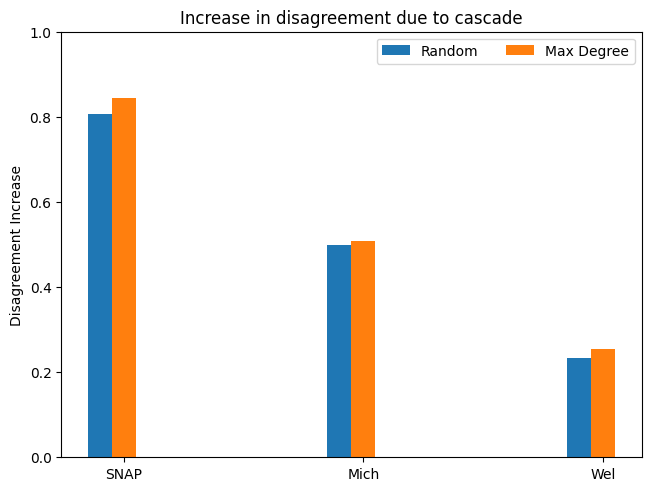

In [13]:
def polarization_difference(results_df, plot=True):
    # Filter for edges = 0
    results_df_0_edges = results_df[results_df['edges_added'] == 0]

    # Get random and maxDegree
    results_df_0_edges_random = results_df_0_edges[results_df_0_edges['state_init'] == 'random']
    results_df_0_edges_maxDegree = results_df_0_edges[results_df_0_edges['state_init'] == 'maxDegree']

    if plot:
        plt.figure(figsize=(10, 5))

    # Plot polarization difference of for cascade/noCascade for random
    # Get cascade and noCascade
    results_df_0_edges_random_cascade = results_df_0_edges_random[results_df_0_edges_random['cascade'] == True]['tuple'].iloc[0]
    results_df_0_edges_random_noCascade = results_df_0_edges_random[results_df_0_edges_random['cascade'] == False]['tuple'].iloc[0]

    # Get difference
    polarization_difference_random = [results_df_0_edges_random_cascade[6][i] - results_df_0_edges_random_noCascade[6][i] for i in range(len(results_df_0_edges_random_cascade[6]))]
    if plot:
        plt.plot(polarization_difference_random, label='Random')

    # Plot polarization difference of for cascade/noCascade for maxDegree
    # Get cascade and noCascade
    results_df_0_edges_maxDegree_cascade = results_df_0_edges_maxDegree[results_df_0_edges_maxDegree['cascade'] == True]['tuple'].iloc[0]
    results_df_0_edges_maxDegree_noCascade = results_df_0_edges_maxDegree[results_df_0_edges_maxDegree['cascade'] == False]['tuple'].iloc[0]

    # Get difference
    polarization_difference_maxDegree = [results_df_0_edges_maxDegree_cascade[6][i] - results_df_0_edges_maxDegree_noCascade[6][i] for i in range(len(results_df_0_edges_maxDegree_cascade[6]))]
    if plot:
        plt.plot(polarization_difference_maxDegree, label='Max Degree')

    # Plot grey dotted line at 0
    if plot:
        plt.plot([0 for i in range(len(polarization_difference_random))], '--', color='grey')

    if plot:
        plt.legend()
        plt.xlabel('Rounds')
        plt.ylabel('Polarization')
        plt.title('Polarization vs rounds')
        plt.show()

    return polarization_difference_random, polarization_difference_maxDegree

def disagreement_difference(results_df, plot=True):
    # Filter for edges = 0
    results_df_0_edges = results_df[results_df['edges_added'] == 0]

    # Get random and maxDegree
    results_df_0_edges_random = results_df_0_edges[results_df_0_edges['state_init'] == 'random']
    results_df_0_edges_maxDegree = results_df_0_edges[results_df_0_edges['state_init'] == 'maxDegree']

    if plot:
        plt.figure(figsize=(10, 5))

    # Plot disagreement difference of for cascade/noCascade for random
    # Get cascade and noCascade
    results_df_0_edges_random_cascade = results_df_0_edges_random[results_df_0_edges_random['cascade'] == True]['tuple'].iloc[0]
    results_df_0_edges_random_noCascade = results_df_0_edges_random[results_df_0_edges_random['cascade'] == False]['tuple'].iloc[0]

    # Get difference
    disagreement_difference_random = [results_df_0_edges_random_cascade[9][i] - results_df_0_edges_random_noCascade[9][i] for i in range(len(results_df_0_edges_random_cascade[9]))]
    if plot:
        plt.plot(disagreement_difference_random, label='Random')

    # Plot disagreement difference of for cascade/noCascade for maxDegree
    # Get cascade and noCascade
    results_df_0_edges_maxDegree_cascade = results_df_0_edges_maxDegree[results_df_0_edges_maxDegree['cascade'] == True]['tuple'].iloc[0]
    results_df_0_edges_maxDegree_noCascade = results_df_0_edges_maxDegree[results_df_0_edges_maxDegree['cascade'] == False]['tuple'].iloc[0]

    # Get difference
    disagreement_difference_maxDegree = [results_df_0_edges_maxDegree_cascade[9][i] - results_df_0_edges_maxDegree_noCascade[9][i] for i in range(len(results_df_0_edges_maxDegree_cascade[9]))]
    if plot:
        plt.plot(disagreement_difference_maxDegree, label='Max Degree')

    # Plot grey dotted line at 0
    if plot:
        plt.plot([0 for i in range(len(disagreement_difference_random))], '--', color='grey')

    if plot:
        plt.legend()
        plt.xlabel('Rounds')
        plt.ylabel('Disagreement')
        plt.title('Disagreement vs rounds')
        plt.show()
    
    return disagreement_difference_random, disagreement_difference_maxDegree

# Get polarization difference
snap_polarization_diff_random, snap_polarization_diff_maxDeg = polarization_difference(results_df_snap, plot=False)
wel_polarization_diff_random, wel_polarization_diff_maxDeg = polarization_difference(results_df_wel, plot=False)
mich_polarization_diff_random, mich_polarization_diff_maxDeg = polarization_difference(results_df_mich, plot=False)

# Get disagreement difference
snap_disagreement_diff_random, snap_disagreement_diff_maxDeg = disagreement_difference(results_df_snap, plot=False)
wel_disagreement_diff_random, wel_disagreement_diff_maxDeg = disagreement_difference(results_df_wel, plot=False)
mich_disagreement_diff_random, mich_disagreement_diff_maxDeg = disagreement_difference(results_df_mich, plot=False)

Datasets = ("SNAP", "Mich", "Wel")
initialization_method = {
    'Random': (snap_polarization_diff_random[-1], wel_polarization_diff_random[-1], mich_polarization_diff_random[-1]),
    'Max Degree': (snap_polarization_diff_maxDeg[-1], wel_polarization_diff_maxDeg[-1], mich_polarization_diff_maxDeg[-1])
}
x = np.arange(len(Datasets))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(constrained_layout=True)
for attribute, measurement in initialization_method.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Polarization Increase')
ax.set_title('Increase in polarization due to cascade')
ax.set_xticks(x + width, Datasets)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 1)
plt.show()



initialization_method = {
    'Random': (snap_disagreement_diff_random[-1], wel_disagreement_diff_random[-1], mich_disagreement_diff_random[-1]),
    'Max Degree': (snap_disagreement_diff_maxDeg[-1], wel_disagreement_diff_maxDeg[-1], mich_disagreement_diff_maxDeg[-1])
}
multiplier = 0
fig, ax = plt.subplots(constrained_layout=True)
for attribute, measurement in initialization_method.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Disagreement Increase')
ax.set_title('Increase in disagreement due to cascade')
ax.set_xticks(x + width, Datasets)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 1)
plt.show()

In [14]:
# Plot state counts for random and maxDegree over time
def plot_state_counts(results_df_1, results_df_2, results_df_3, title_1, title_2, title_3):
    # Filter for edges = 0
    results_df_0_edges_1 = results_df_1[results_df_1['edges_added'] == 0]
    results_df_0_edges_2 = results_df_2[results_df_2['edges_added'] == 0]
    results_df_0_edges_3 = results_df_3[results_df_3['edges_added'] == 0]

    # Split by state_init
    results_df_0_edges_random_1 = results_df_0_edges_1[results_df_0_edges_1['state_init'] == 'random']
    results_df_0_edges_maxDegree_1 = results_df_0_edges_1[results_df_0_edges_1['state_init'] == 'maxDegree']
    results_df_0_edges_random_2 = results_df_0_edges_2[results_df_0_edges_2['state_init'] == 'random']
    results_df_0_edges_maxDegree_2 = results_df_0_edges_2[results_df_0_edges_2['state_init'] == 'maxDegree']
    results_df_0_edges_random_3 = results_df_0_edges_3[results_df_0_edges_3['state_init'] == 'random']
    results_df_0_edges_maxDegree_3 = results_df_0_edges_3[results_df_0_edges_3['state_init'] == 'maxDegree']

    # Split by cascade
    results_df_0_edges_random_cascade_1 = results_df_0_edges_random_1[results_df_0_edges_random_1['cascade'] == True]
    results_df_0_edges_maxDegree_cascade_1 = results_df_0_edges_maxDegree_1[results_df_0_edges_maxDegree_1['cascade'] == True]
    results_df_0_edges_random_cascade_2 = results_df_0_edges_random_2[results_df_0_edges_random_2['cascade'] == True]
    results_df_0_edges_maxDegree_cascade_2 = results_df_0_edges_maxDegree_2[results_df_0_edges_maxDegree_2['cascade'] == True]
    results_df_0_edges_random_cascade_3 = results_df_0_edges_random_3[results_df_0_edges_random_3['cascade'] == True]
    results_df_0_edges_maxDegree_cascade_3 = results_df_0_edges_maxDegree_3[results_df_0_edges_maxDegree_3['cascade'] == True]

    # Get six figure window subplot
    fig, axs = plt.subplots(3, 2, figsize=(10, 15))

    # Row 1
    axs[0, 0].plot(results_df_0_edges_random_cascade_1['tuple'].iloc[0][0], label='Ignore')
    axs[0, 0].plot(results_df_0_edges_random_cascade_1['tuple'].iloc[0][1], label='Acknowledge')
    axs[0, 0].plot(results_df_0_edges_random_cascade_1['tuple'].iloc[0][2], label='Spread')
    axs[0, 0].plot(results_df_0_edges_random_cascade_1['tuple'].iloc[0][3], label='Removed')
    axs[0, 0].set_title(title_1 + ' - Random')
    axs[0, 0].set_xlabel('Rounds')
    axs[0, 0].set_ylabel('Polarization')
    axs[0, 0].legend()
    axs[0, 1].plot(results_df_0_edges_maxDegree_cascade_1['tuple'].iloc[0][0], label='Ignore')
    axs[0, 1].plot(results_df_0_edges_maxDegree_cascade_1['tuple'].iloc[0][1], label='Acknowledge')
    axs[0, 1].plot(results_df_0_edges_maxDegree_cascade_1['tuple'].iloc[0][2], label='Spread')
    axs[0, 1].plot(results_df_0_edges_maxDegree_cascade_1['tuple'].iloc[0][3], label='Removed')
    axs[0, 1].set_title(title_1 + ' - Max Degree')
    axs[0, 1].set_xlabel('Rounds')
    axs[0, 1].set_ylabel('Polarization')
    axs[0, 1].legend()

    # Row 2
    axs[1, 0].plot(results_df_0_edges_random_cascade_2['tuple'].iloc[0][0], label='Ignore')
    axs[1, 0].plot(results_df_0_edges_random_cascade_2['tuple'].iloc[0][1], label='Acknowledge')
    axs[1, 0].plot(results_df_0_edges_random_cascade_2['tuple'].iloc[0][2], label='Spread')
    axs[1, 0].plot(results_df_0_edges_random_cascade_2['tuple'].iloc[0][3], label='Removed')
    axs[1, 0].set_title(title_2 + ' - Random')
    axs[1, 0].set_xlabel('Rounds')
    axs[1, 0].set_ylabel('Polarization')
    axs[1, 0].legend()
    axs[1, 1].plot(results_df_0_edges_maxDegree_cascade_2['tuple'].iloc[0][0], label='Ignore')
    axs[1, 1].plot(results_df_0_edges_maxDegree_cascade_2['tuple'].iloc[0][1], label='Acknowledge')
    axs[1, 1].plot(results_df_0_edges_maxDegree_cascade_2['tuple'].iloc[0][2], label='Spread')
    axs[1, 1].plot(results_df_0_edges_maxDegree_cascade_2['tuple'].iloc[0][3], label='Removed')
    axs[1, 1].set_title(title_2 + ' - Max Degree')
    axs[1, 1].set_xlabel('Rounds')
    axs[1, 1].set_ylabel('Polarization')
    axs[1, 1].legend()

    # Row 3
    axs[2, 0].plot(results_df_0_edges_random_cascade_3['tuple'].iloc[0][0], label='Ignore')
    axs[2, 0].plot(results_df_0_edges_random_cascade_3['tuple'].iloc[0][1], label='Acknowledge')
    axs[2, 0].plot(results_df_0_edges_random_cascade_3['tuple'].iloc[0][2], label='Spread')
    axs[2, 0].plot(results_df_0_edges_random_cascade_3['tuple'].iloc[0][3], label='Removed')
    axs[2, 0].set_title(title_3 + ' - Random')
    axs[2, 0].set_xlabel('Rounds')
    axs[2, 0].set_ylabel('Polarization')
    axs[2, 0].legend()
    axs[2, 1].plot(results_df_0_edges_maxDegree_cascade_3['tuple'].iloc[0][0], label='Ignore')
    axs[2, 1].plot(results_df_0_edges_maxDegree_cascade_3['tuple'].iloc[0][1], label='Acknowledge')
    axs[2, 1].plot(results_df_0_edges_maxDegree_cascade_3['tuple'].iloc[0][2], label='Spread')
    axs[2, 1].plot(results_df_0_edges_maxDegree_cascade_3['tuple'].iloc[0][3], label='Removed')
    axs[2, 1].set_title(title_3 + ' - Max Degree')
    axs[2, 1].set_xlabel('Rounds')
    axs[2, 1].set_ylabel('Polarization')
    axs[2, 1].legend()

    fig = plt.gcf()
    fig.suptitle("State counts over time", fontsize=14)
    fig.tight_layout()

    plt.show()

# Plot external, internal, and total polarization
def compare_polarizations(results_df_1, results_df_2, results_df_3, title_1, title_2, title_3):
    # Filter for edges = 0
    results_df_0_edges_1 = results_df_1[results_df_1['edges_added'] == 0]
    results_df_0_edges_2 = results_df_2[results_df_2['edges_added'] == 0]
    results_df_0_edges_3 = results_df_3[results_df_3['edges_added'] == 0]

    # Split by state_init
    results_df_0_edges_random_1 = results_df_0_edges_1[results_df_0_edges_1['state_init'] == 'random']
    results_df_0_edges_maxDegree_1 = results_df_0_edges_1[results_df_0_edges_1['state_init'] == 'maxDegree']
    results_df_0_edges_random_2 = results_df_0_edges_2[results_df_0_edges_2['state_init'] == 'random']
    results_df_0_edges_maxDegree_2 = results_df_0_edges_2[results_df_0_edges_2['state_init'] == 'maxDegree']
    results_df_0_edges_random_3 = results_df_0_edges_3[results_df_0_edges_3['state_init'] == 'random']
    results_df_0_edges_maxDegree_3 = results_df_0_edges_3[results_df_0_edges_3['state_init'] == 'maxDegree']

    # Split by cascade
    results_df_0_edges_random_cascade_1 = results_df_0_edges_random_1[results_df_0_edges_random_1['cascade'] == True]
    results_df_0_edges_maxDegree_cascade_1 = results_df_0_edges_maxDegree_1[results_df_0_edges_maxDegree_1['cascade'] == True]
    results_df_0_edges_random_cascade_2 = results_df_0_edges_random_2[results_df_0_edges_random_2['cascade'] == True]
    results_df_0_edges_maxDegree_cascade_2 = results_df_0_edges_maxDegree_2[results_df_0_edges_maxDegree_2['cascade'] == True]
    results_df_0_edges_random_cascade_3 = results_df_0_edges_random_3[results_df_0_edges_random_3['cascade'] == True]
    results_df_0_edges_maxDegree_cascade_3 = results_df_0_edges_maxDegree_3[results_df_0_edges_maxDegree_3['cascade'] == True]

    # Get six figure window subplot
    fig, axs = plt.subplots(3, 2, figsize=(10, 15))

    # Row 1
    axs[0, 0].plot(results_df_0_edges_random_cascade_1['tuple'].iloc[0][4], label='External')
    axs[0, 0].plot(results_df_0_edges_random_cascade_1['tuple'].iloc[0][5], label='Internal')
    axs[0, 0].plot(results_df_0_edges_random_cascade_1['tuple'].iloc[0][6], label='Total')
    axs[0, 0].set_title(title_1 + ' - Random')
    axs[0, 0].set_xlabel('Rounds')
    axs[0, 0].set_ylabel('Polarization')
    axs[0, 0].legend()
    axs[0, 1].plot(results_df_0_edges_maxDegree_cascade_1['tuple'].iloc[0][4], label='External')
    axs[0, 1].plot(results_df_0_edges_maxDegree_cascade_1['tuple'].iloc[0][5], label='Internal')
    axs[0, 1].plot(results_df_0_edges_maxDegree_cascade_1['tuple'].iloc[0][6], label='Total')
    axs[0, 1].set_title(title_1 + ' - Max Degree')
    axs[0, 1].set_xlabel('Rounds')
    axs[0, 1].set_ylabel('Polarization')
    axs[0, 1].legend()

    # Row 2
    axs[1, 0].plot(results_df_0_edges_random_cascade_2['tuple'].iloc[0][4], label='External')
    axs[1, 0].plot(results_df_0_edges_random_cascade_2['tuple'].iloc[0][5], label='Internal')
    axs[1, 0].plot(results_df_0_edges_random_cascade_2['tuple'].iloc[0][6], label='Total')
    axs[1, 0].set_title(title_2 + ' - Random')
    axs[1, 0].set_xlabel('Rounds')
    axs[1, 0].set_ylabel('Polarization')
    axs[1, 0].legend()
    axs[1, 1].plot(results_df_0_edges_maxDegree_cascade_2['tuple'].iloc[0][4], label='External')
    axs[1, 1].plot(results_df_0_edges_maxDegree_cascade_2['tuple'].iloc[0][5], label='Internal')
    axs[1, 1].plot(results_df_0_edges_maxDegree_cascade_2['tuple'].iloc[0][6], label='Total')
    axs[1, 1].set_title(title_2 + ' - Max Degree')
    axs[1, 1].set_xlabel('Rounds')
    axs[1, 1].set_ylabel('Polarization')
    axs[1, 1].legend()

    # Row 3
    axs[2, 0].plot(results_df_0_edges_random_cascade_3['tuple'].iloc[0][4], label='External')
    axs[2, 0].plot(results_df_0_edges_random_cascade_3['tuple'].iloc[0][5], label='Internal')
    axs[2, 0].plot(results_df_0_edges_random_cascade_3['tuple'].iloc[0][6], label='Total')
    axs[2, 0].set_title(title_3 + ' - Random')
    axs[2, 0].set_xlabel('Rounds')
    axs[2, 0].set_ylabel('Polarization')
    axs[2, 0].legend()
    axs[2, 1].plot(results_df_0_edges_maxDegree_cascade_3['tuple'].iloc[0][4], label='External')
    axs[2, 1].plot(results_df_0_edges_maxDegree_cascade_3['tuple'].iloc[0][5], label='Internal')
    axs[2, 1].plot(results_df_0_edges_maxDegree_cascade_3['tuple'].iloc[0][6], label='Total')
    axs[2, 1].set_title(title_3 + ' - Max Degree')
    axs[2, 1].set_xlabel('Rounds')
    axs[2, 1].set_ylabel('Polarization')
    axs[2, 1].legend()

    fig = plt.gcf()
    fig.suptitle("Polarization over time", fontsize=14)
    fig.tight_layout()

    # Show plot
    plt.show()

def compare_disagreements(results_df_1, results_df_2, results_df_3, title_1, title_2, title_3):
    # Filter for edges = 0
    results_df_0_edges_1 = results_df_1[results_df_1['edges_added'] == 0]
    results_df_0_edges_2 = results_df_2[results_df_2['edges_added'] == 0]
    results_df_0_edges_3 = results_df_3[results_df_3['edges_added'] == 0]

    # Split by state_init
    results_df_0_edges_random_1 = results_df_0_edges_1[results_df_0_edges_1['state_init'] == 'random']
    results_df_0_edges_maxDegree_1 = results_df_0_edges_1[results_df_0_edges_1['state_init'] == 'maxDegree']
    results_df_0_edges_random_2 = results_df_0_edges_2[results_df_0_edges_2['state_init'] == 'random']
    results_df_0_edges_maxDegree_2 = results_df_0_edges_2[results_df_0_edges_2['state_init'] == 'maxDegree']
    results_df_0_edges_random_3 = results_df_0_edges_3[results_df_0_edges_3['state_init'] == 'random']
    results_df_0_edges_maxDegree_3 = results_df_0_edges_3[results_df_0_edges_3['state_init'] == 'maxDegree']

    # Split by cascade
    results_df_0_edges_random_cascade_1 = results_df_0_edges_random_1[results_df_0_edges_random_1['cascade'] == True]
    results_df_0_edges_maxDegree_cascade_1 = results_df_0_edges_maxDegree_1[results_df_0_edges_maxDegree_1['cascade'] == True]
    results_df_0_edges_random_cascade_2 = results_df_0_edges_random_2[results_df_0_edges_random_2['cascade'] == True]
    results_df_0_edges_maxDegree_cascade_2 = results_df_0_edges_maxDegree_2[results_df_0_edges_maxDegree_2['cascade'] == True]
    results_df_0_edges_random_cascade_3 = results_df_0_edges_random_3[results_df_0_edges_random_3['cascade'] == True]
    results_df_0_edges_maxDegree_cascade_3 = results_df_0_edges_maxDegree_3[results_df_0_edges_maxDegree_3['cascade'] == True]

    # Get six figure window subplot
    fig, axs = plt.subplots(3, 2, figsize=(10, 15))

    # Row 1
    axs[0, 0].plot(results_df_0_edges_random_cascade_1['tuple'].iloc[0][7], label='External')
    axs[0, 0].plot(results_df_0_edges_random_cascade_1['tuple'].iloc[0][8], label='Internal')
    axs[0, 0].plot(results_df_0_edges_random_cascade_1['tuple'].iloc[0][9], label='Total')
    axs[0, 0].set_title(title_1 + ' - Random')
    axs[0, 0].set_xlabel('Rounds')
    axs[0, 0].set_ylabel('Disagreements')
    axs[0, 0].legend()
    axs[0, 1].plot(results_df_0_edges_maxDegree_cascade_1['tuple'].iloc[0][7], label='External')
    axs[0, 1].plot(results_df_0_edges_maxDegree_cascade_1['tuple'].iloc[0][8], label='Internal')
    axs[0, 1].plot(results_df_0_edges_maxDegree_cascade_1['tuple'].iloc[0][9], label='Total')
    axs[0, 1].set_title(title_1 + ' - Max Degree')
    axs[0, 1].set_xlabel('Rounds')
    axs[0, 1].set_ylabel('Disagreements')
    axs[0, 1].legend()

    # Row 2
    axs[1, 0].plot(results_df_0_edges_random_cascade_2['tuple'].iloc[0][7], label='External')
    axs[1, 0].plot(results_df_0_edges_random_cascade_2['tuple'].iloc[0][8], label='Internal')
    axs[1, 0].plot(results_df_0_edges_random_cascade_2['tuple'].iloc[0][9], label='Total')
    axs[1, 0].set_title(title_2 + ' - Random')
    axs[1, 0].set_xlabel('Rounds')
    axs[1, 0].set_ylabel('Disagreements')
    axs[1, 0].legend()
    axs[1, 1].plot(results_df_0_edges_maxDegree_cascade_2['tuple'].iloc[0][7], label='External')
    axs[1, 1].plot(results_df_0_edges_maxDegree_cascade_2['tuple'].iloc[0][8], label='Internal')
    axs[1, 1].plot(results_df_0_edges_maxDegree_cascade_2['tuple'].iloc[0][9], label='Total')
    axs[1, 1].set_title(title_2 + ' - Max Degree')
    axs[1, 1].set_xlabel('Rounds')
    axs[1, 1].set_ylabel('Disagreements')
    axs[1, 1].legend()

    # Row 3
    axs[2, 0].plot(results_df_0_edges_random_cascade_3['tuple'].iloc[0][7], label='External')
    axs[2, 0].plot(results_df_0_edges_random_cascade_3['tuple'].iloc[0][8], label='Internal')
    axs[2, 0].plot(results_df_0_edges_random_cascade_3['tuple'].iloc[0][9], label='Total')
    axs[2, 0].set_title(title_3 + ' - Random')
    axs[2, 0].set_xlabel('Rounds')
    axs[2, 0].set_ylabel('Disagreements')
    axs[2, 0].legend()
    axs[2, 1].plot(results_df_0_edges_maxDegree_cascade_3['tuple'].iloc[0][7], label='External')
    axs[2, 1].plot(results_df_0_edges_maxDegree_cascade_3['tuple'].iloc[0][8], label='Internal')
    axs[2, 1].plot(results_df_0_edges_maxDegree_cascade_3['tuple'].iloc[0][9], label='Total')
    axs[2, 1].set_title(title_3 + ' - Max Degree')
    axs[2, 1].set_xlabel('Rounds')
    axs[2, 1].set_ylabel('Disagreements')
    axs[2, 1].legend()

    fig = plt.gcf()
    fig.suptitle("Disagreement over time", fontsize=14)
    fig.tight_layout()

    plt.show()

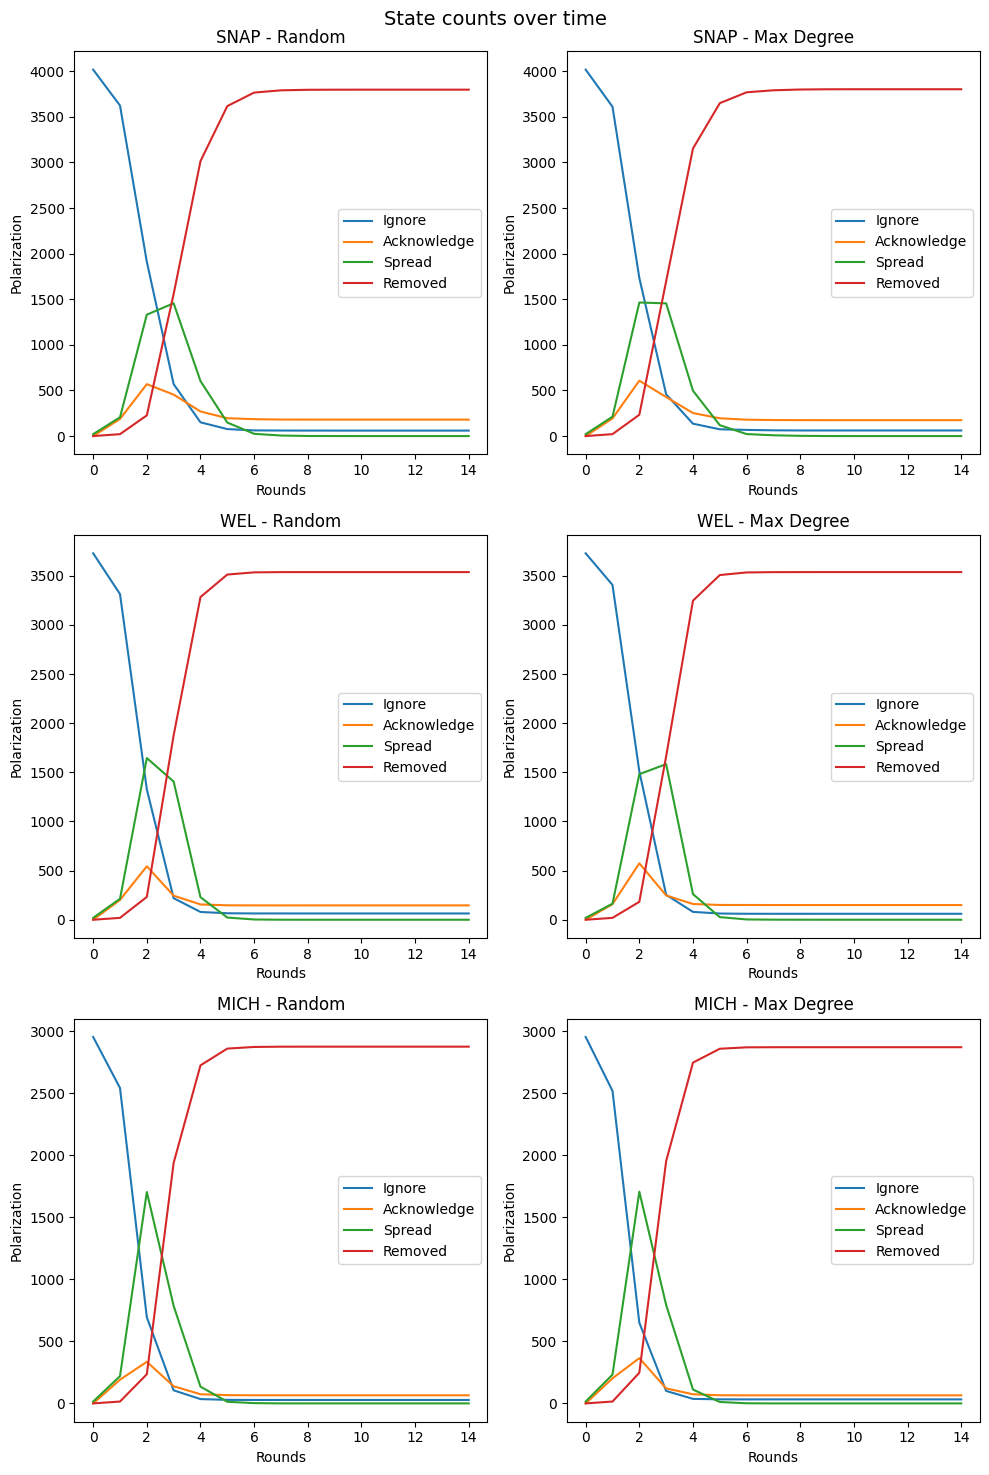

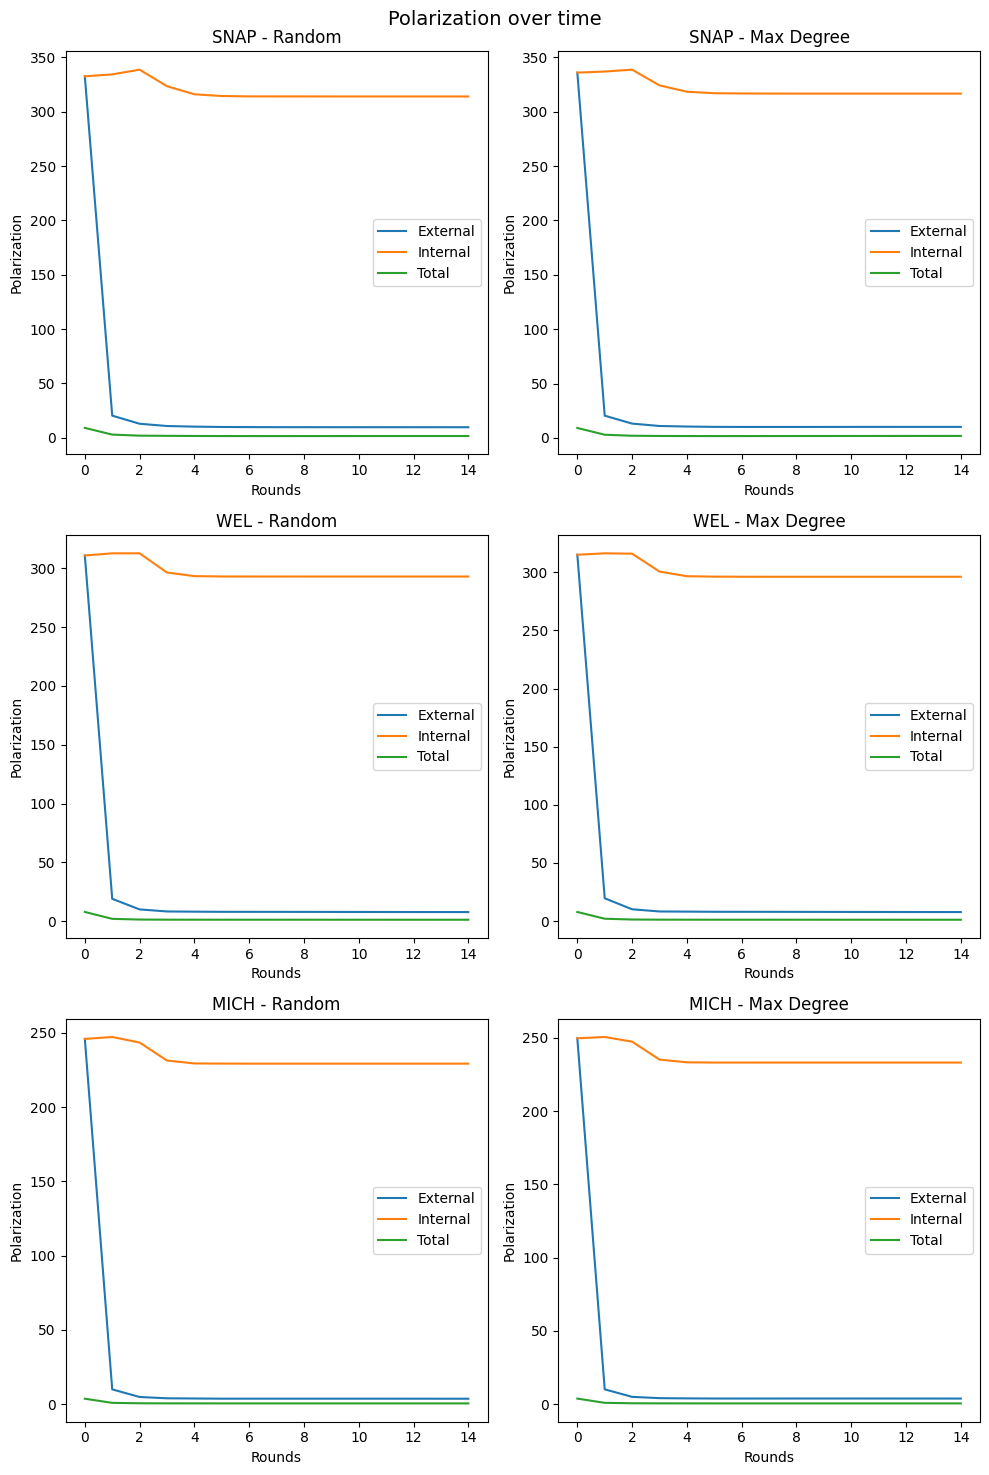

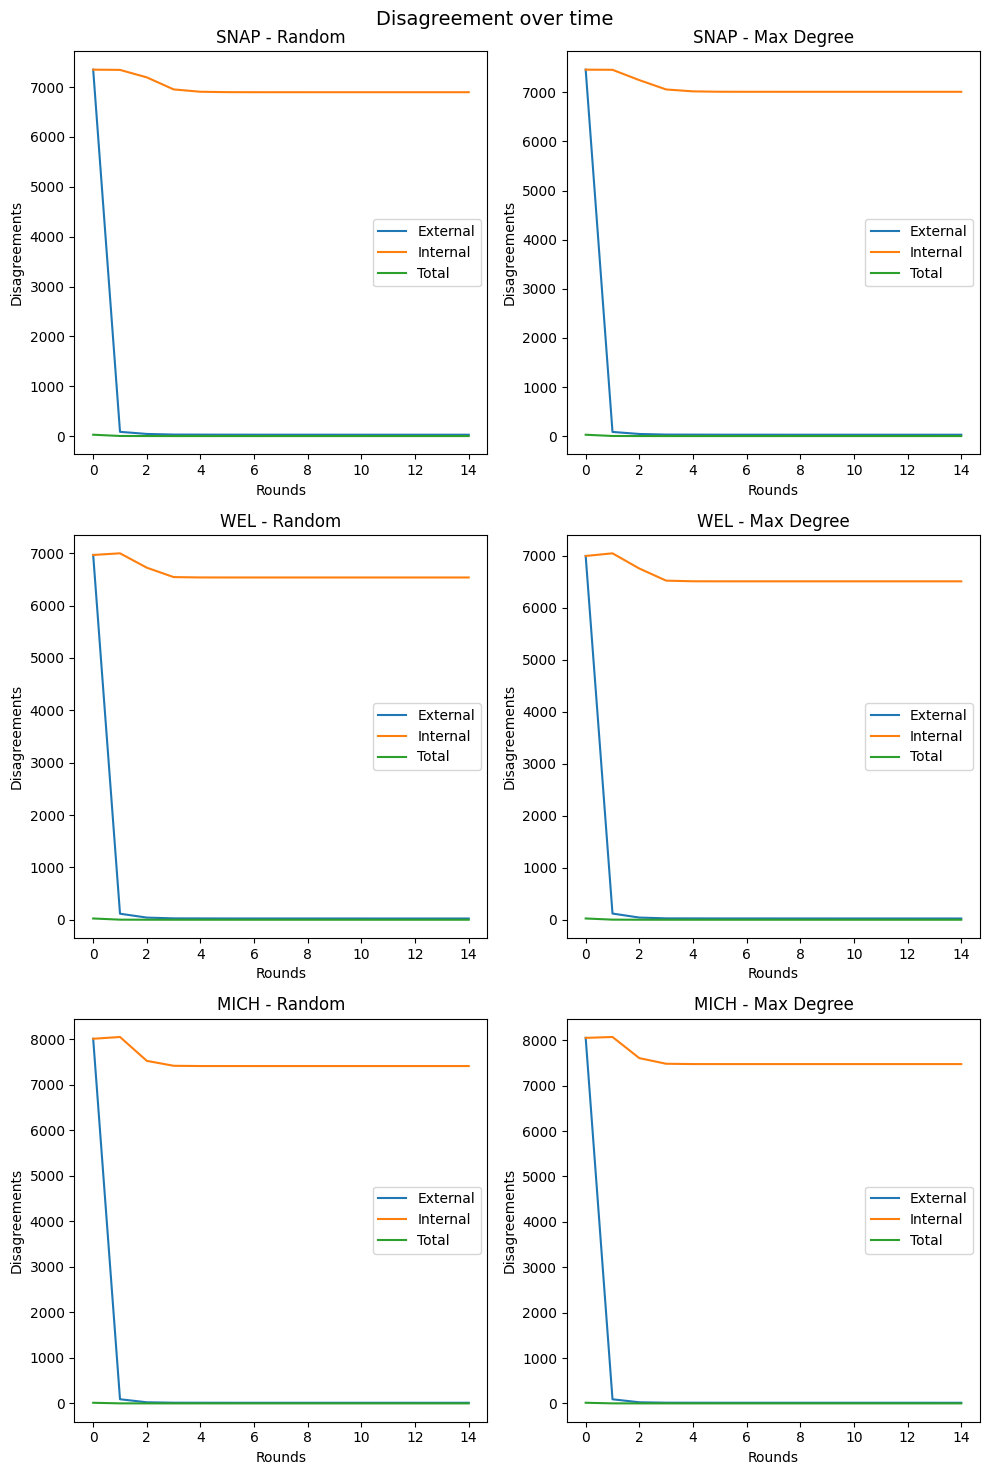

In [15]:
plot_state_counts(results_df_snap, results_df_wel, results_df_mich, "SNAP", "WEL", "MICH")
compare_polarizations(results_df_snap, results_df_wel, results_df_mich, "SNAP", "WEL", "MICH")
compare_disagreements(results_df_snap, results_df_wel, results_df_mich, "SNAP", "WEL", "MICH")

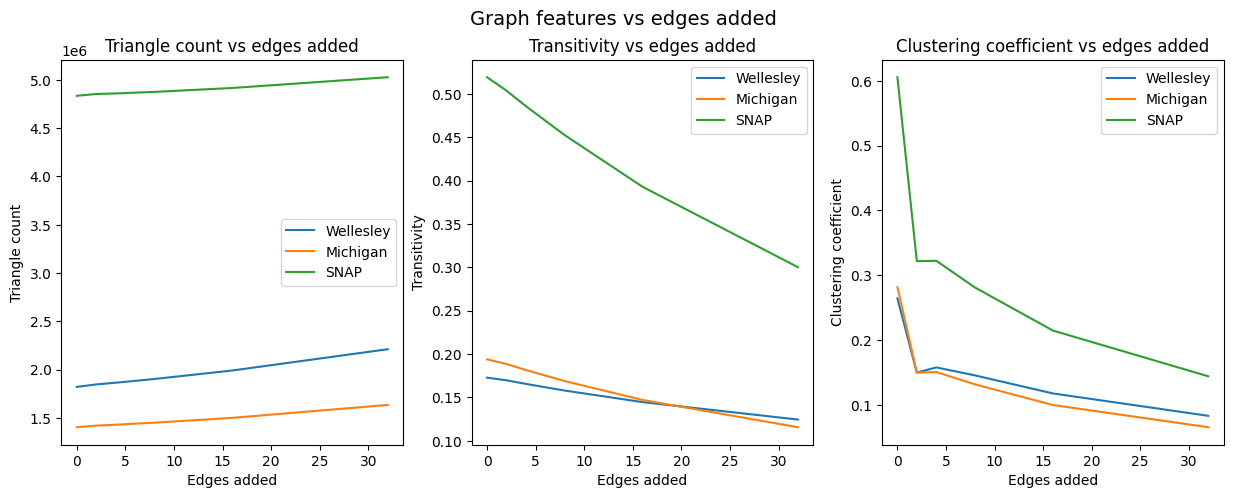

In [17]:
# Load graph_features_fb_wel.pickle, graph_features_fb_mich.pickle, graph_features_fb.pickle
with open('graph_features\graph_features_fb_wel.pickle', 'rb') as handle:
    graph_features_fb_wel = pickle.load(handle)
with open('graph_features\graph_features_fb_mich.pickle', 'rb') as handle:
    graph_features_fb_mich = pickle.load(handle)
with open('graph_features\graph_features_fb.pickle', 'rb') as handle:
    graph_features_fb = pickle.load(handle)

# Collect third entry of every array into a list
triangles_fb_wel = [graph_features_fb_wel[i][2] for i in range(len(graph_features_fb_wel))]
triangles_fb_mich = [graph_features_fb_mich[i][2] for i in range(len(graph_features_fb_mich))]
triangles_fb = [graph_features_fb[i][2] for i in range(len(graph_features_fb))]

# Collect fourth entry of every array into a list
transitivity_fb_wel = [graph_features_fb_wel[i][3] for i in range(len(graph_features_fb_wel))]
transitivity_fb_mich = [graph_features_fb_mich[i][3] for i in range(len(graph_features_fb_mich))]
transitivity_fb = [graph_features_fb[i][3] for i in range(len(graph_features_fb))]

# Collect fifth entry of every array into a list
clustering_fb_wel = [graph_features_fb_wel[i][4] for i in range(len(graph_features_fb_wel))]
clustering_fb_mich = [graph_features_fb_mich[i][4] for i in range(len(graph_features_fb_mich))]
clustering_fb = [graph_features_fb[i][4] for i in range(len(graph_features_fb))]

d_edges = [0, 2, 4, 8, 16, 32]

# Create 3 horizontal subplots to display the triangle count, transitivity and clustering coefficient
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(d_edges, triangles_fb_wel, label='Wellesley')
axs[0].plot(d_edges, triangles_fb_mich, label='Michigan')
axs[0].plot(d_edges, triangles_fb, label='SNAP')
axs[0].set_title('Triangle count vs edges added')
axs[0].set_xlabel('Edges added')
axs[0].set_ylabel('Triangle count')
axs[0].legend()

axs[1].plot(d_edges, transitivity_fb_wel, label='Wellesley')
axs[1].plot(d_edges, transitivity_fb_mich, label='Michigan')
axs[1].plot(d_edges, transitivity_fb, label='SNAP')
axs[1].set_title('Transitivity vs edges added')
axs[1].set_xlabel('Edges added')
axs[1].set_ylabel('Transitivity')
axs[1].legend()

axs[2].plot(d_edges, clustering_fb_wel, label='Wellesley')
axs[2].plot(d_edges, clustering_fb_mich, label='Michigan')
axs[2].plot(d_edges, clustering_fb, label='SNAP')
axs[2].set_title('Clustering coefficient vs edges added')
axs[2].set_xlabel('Edges added')
axs[2].set_ylabel('Clustering coefficient')
axs[2].legend()

fig = plt.gcf()
fig.suptitle("Graph features vs edges added", fontsize=14)
plt.show()

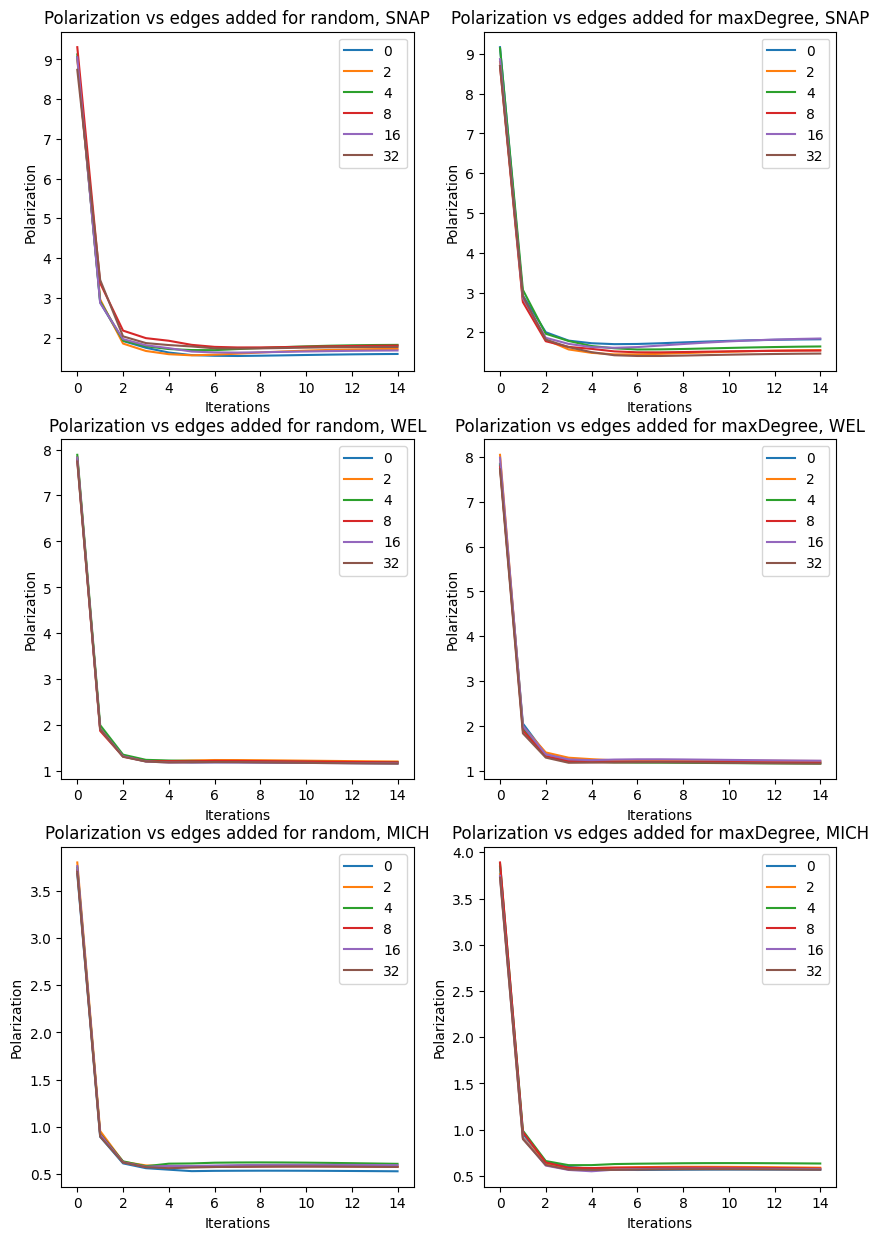

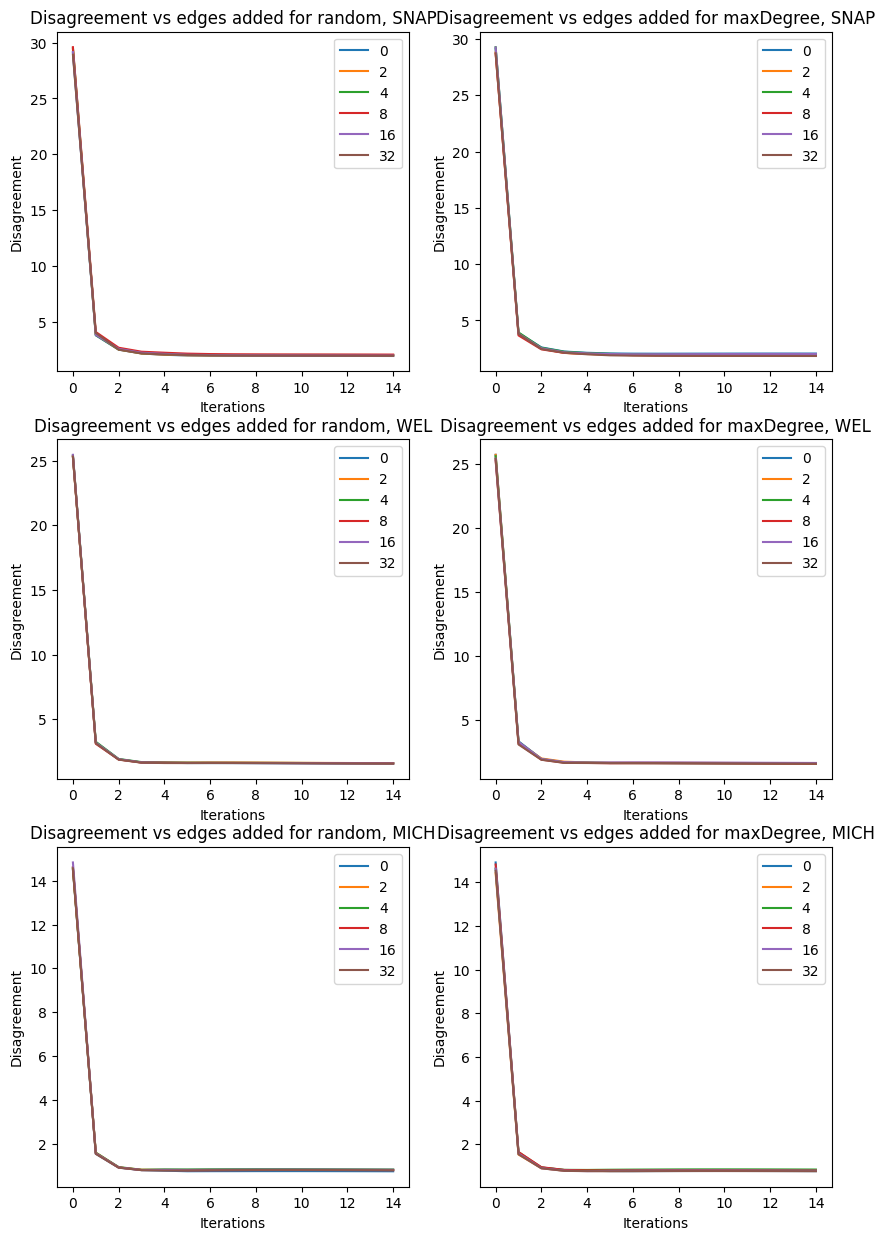

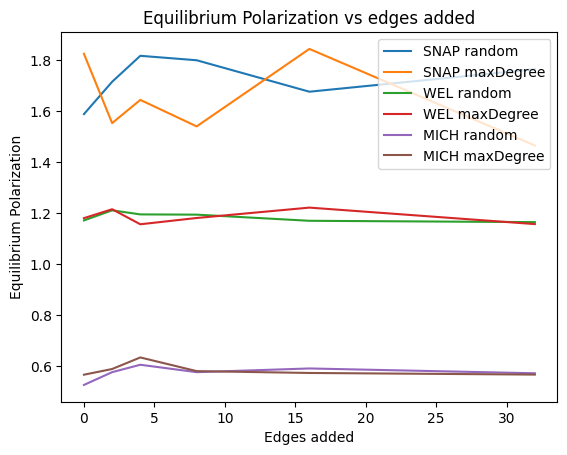

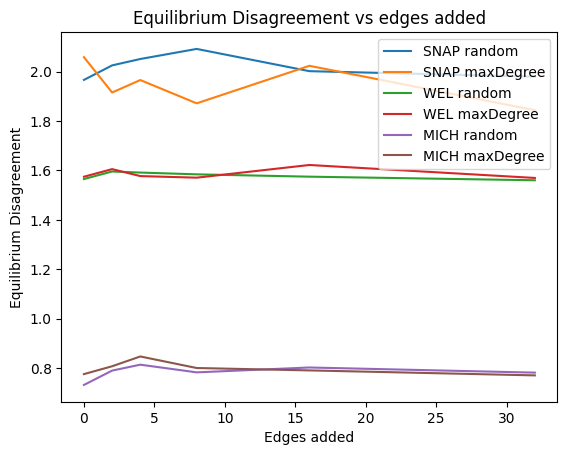

In [20]:
# Polarization vs edges added
def polarization_vs_edges(results_df_1, results_df_2, results_df_3, title_1, title_2, title_3):
    # Filter each for cascade
    results_df_1 = results_df_1[results_df_1['cascade'] == True]
    results_df_2 = results_df_2[results_df_2['cascade'] == True]
    results_df_3 = results_df_3[results_df_3['cascade'] == True]

    # Get random and max degree
    results_df_1_random = results_df_1[results_df_1['state_init'] == 'random']
    results_df_1_maxDegree = results_df_1[results_df_1['state_init'] == 'maxDegree']
    results_df_2_random = results_df_2[results_df_2['state_init'] == 'random']
    results_df_2_maxDegree = results_df_2[results_df_2['state_init'] == 'maxDegree']
    results_df_3_random = results_df_3[results_df_3['state_init'] == 'random']
    results_df_3_maxDegree = results_df_3[results_df_3['state_init'] == 'maxDegree']

    # Get 6 figure plot
    fig, axs = plt.subplots(3,2, figsize=(10, 15))

    # Plot polarization vs edges added for random, data 1
    for edges in d_edges:
        results_df_1_random_edges = results_df_1_random[results_df_1_random['edges_added'] == edges]
        axs[0, 0].plot(results_df_1_random_edges['tuple'].iloc[0][6], label=str(edges))
    axs[0, 0].set_title('Polarization vs edges added for random, ' + title_1)
    axs[0, 0].set_xlabel('Iterations')
    axs[0, 0].set_ylabel('Polarization')
    axs[0, 0].legend()

    # Plot polarization vs edges added for maxDegree, data 1
    for edges in d_edges:
        results_df_1_maxDegree_edges = results_df_1_maxDegree[results_df_1_maxDegree['edges_added'] == edges]
        axs[0, 1].plot(results_df_1_maxDegree_edges['tuple'].iloc[0][6], label=str(edges))
    axs[0, 1].set_title('Polarization vs edges added for maxDegree, ' + title_1)
    axs[0, 1].set_xlabel('Iterations')
    axs[0, 1].set_ylabel('Polarization')
    axs[0, 1].legend()

    # Plot polarization vs edges added for random, data 2
    for edges in d_edges:
        results_df_2_random_edges = results_df_2_random[results_df_2_random['edges_added'] == edges]
        axs[1, 0].plot(results_df_2_random_edges['tuple'].iloc[0][6], label=str(edges))
    axs[1, 0].set_title('Polarization vs edges added for random, ' + title_2)
    axs[1, 0].set_xlabel('Iterations')
    axs[1, 0].set_ylabel('Polarization')
    axs[1, 0].legend()

    # Plot polarization vs edges added for maxDegree, data 2
    for edges in d_edges:
        results_df_2_maxDegree_edges = results_df_2_maxDegree[results_df_2_maxDegree['edges_added'] == edges]
        axs[1, 1].plot(results_df_2_maxDegree_edges['tuple'].iloc[0][6], label=str(edges))
    axs[1, 1].set_title('Polarization vs edges added for maxDegree, ' + title_2)
    axs[1, 1].set_xlabel('Iterations')
    axs[1, 1].set_ylabel('Polarization')
    axs[1, 1].legend()

    # Plot polarization vs edges added for random, data 3
    for edges in d_edges:
        results_df_3_random_edges = results_df_3_random[results_df_3_random['edges_added'] == edges]
        axs[2, 0].plot(results_df_3_random_edges['tuple'].iloc[0][6], label=str(edges))
    axs[2, 0].set_title('Polarization vs edges added for random, ' + title_3)
    axs[2, 0].set_xlabel('Iterations')
    axs[2, 0].set_ylabel('Polarization')
    axs[2, 0].legend()

    # Plot polarization vs edges added for maxDegree, data 3
    for edges in d_edges:
        results_df_3_maxDegree_edges = results_df_3_maxDegree[results_df_3_maxDegree['edges_added'] == edges]
        axs[2, 1].plot(results_df_3_maxDegree_edges['tuple'].iloc[0][6], label=str(edges))
    axs[2, 1].set_title('Polarization vs edges added for maxDegree, ' + title_3)
    axs[2, 1].set_xlabel('Iterations')
    axs[2, 1].set_ylabel('Polarization')
    axs[2, 1].legend()


    plt.show()

# Disagreement vs edges added
def disagreement_vs_edges(results_df_1, results_df_2, results_df_3, title_1, title_2, title_3):
    # Filter each for cascade
    results_df_1 = results_df_1[results_df_1['cascade'] == True]
    results_df_2 = results_df_2[results_df_2['cascade'] == True]
    results_df_3 = results_df_3[results_df_3['cascade'] == True]

    # Get random and max degree
    results_df_1_random = results_df_1[results_df_1['state_init'] == 'random']
    results_df_1_maxDegree = results_df_1[results_df_1['state_init'] == 'maxDegree']
    results_df_2_random = results_df_2[results_df_2['state_init'] == 'random']
    results_df_2_maxDegree = results_df_2[results_df_2['state_init'] == 'maxDegree']
    results_df_3_random = results_df_3[results_df_3['state_init'] == 'random']
    results_df_3_maxDegree = results_df_3[results_df_3['state_init'] == 'maxDegree']

    # Get 6 figure plot
    fig, axs = plt.subplots(3,2, figsize=(10, 15))

    # Plot disagreement vs edges added for random, data 1
    for edges in d_edges:
        results_df_1_random_edges = results_df_1_random[results_df_1_random['edges_added'] == edges]
        axs[0, 0].plot(results_df_1_random_edges['tuple'].iloc[0][9], label=str(edges))
    axs[0, 0].set_title('Disagreement vs edges added for random, ' + title_1)
    axs[0, 0].set_xlabel('Iterations')
    axs[0, 0].set_ylabel('Disagreement')
    axs[0, 0].legend()

    # Plot disagreement vs edges added for maxDegree, data 1
    for edges in d_edges:
        results_df_1_maxDegree_edges = results_df_1_maxDegree[results_df_1_maxDegree['edges_added'] == edges]
        axs[0, 1].plot(results_df_1_maxDegree_edges['tuple'].iloc[0][9], label=str(edges))
    axs[0, 1].set_title('Disagreement vs edges added for maxDegree, ' + title_1)
    axs[0, 1].set_xlabel('Iterations')
    axs[0, 1].set_ylabel('Disagreement')
    axs[0, 1].legend()

    # Plot disagreement vs edges added for random, data 2
    for edges in d_edges:
        results_df_2_random_edges = results_df_2_random[results_df_2_random['edges_added'] == edges]
        axs[1, 0].plot(results_df_2_random_edges['tuple'].iloc[0][9], label=str(edges))
    axs[1, 0].set_title('Disagreement vs edges added for random, ' + title_2)
    axs[1, 0].set_xlabel('Iterations')
    axs[1, 0].set_ylabel('Disagreement')
    axs[1, 0].legend()

    # Plot disagreement vs edges added for maxDegree, data 2
    for edges in d_edges:
        results_df_2_maxDegree_edges = results_df_2_maxDegree[results_df_2_maxDegree['edges_added'] == edges]
        axs[1, 1].plot(results_df_2_maxDegree_edges['tuple'].iloc[0][9], label=str(edges))
    axs[1, 1].set_title('Disagreement vs edges added for maxDegree, ' + title_2)
    axs[1, 1].set_xlabel('Iterations')
    axs[1, 1].set_ylabel('Disagreement')
    axs[1, 1].legend()

    # Plot disagreement vs edges added for random, data 3
    for edges in d_edges:
        results_df_3_random_edges = results_df_3_random[results_df_3_random['edges_added'] == edges]
        axs[2, 0].plot(results_df_3_random_edges['tuple'].iloc[0][9], label=str(edges))
    axs[2, 0].set_title('Disagreement vs edges added for random, ' + title_3)
    axs[2, 0].set_xlabel('Iterations')
    axs[2, 0].set_ylabel('Disagreement')
    axs[2, 0].legend()

    # Plot disagreement vs edges added for maxDegree, data 3
    for edges in d_edges:
        results_df_3_maxDegree_edges = results_df_3_maxDegree[results_df_3_maxDegree['edges_added'] == edges]
        axs[2, 1].plot(results_df_3_maxDegree_edges['tuple'].iloc[0][9], label=str(edges))
    axs[2, 1].set_title('Disagreement vs edges added for maxDegree, ' + title_3)
    axs[2, 1].set_xlabel('Iterations')
    axs[2, 1].set_ylabel('Disagreement')
    axs[2, 1].legend()


    plt.show()

def simplified_polarization_vs_edges(results_df_1, results_df_2, results_df_3, title_1, title_2, title_3):
    # Filter each for cascade
    results_df_1 = results_df_1[results_df_1['cascade'] == True]
    results_df_2 = results_df_2[results_df_2['cascade'] == True]
    results_df_3 = results_df_3[results_df_3['cascade'] == True]

    # Get random and max degree
    results_df_1_random = results_df_1[results_df_1['state_init'] == 'random']
    results_df_1_maxDegree = results_df_1[results_df_1['state_init'] == 'maxDegree']
    results_df_2_random = results_df_2[results_df_2['state_init'] == 'random']
    results_df_2_maxDegree = results_df_2[results_df_2['state_init'] == 'maxDegree']
    results_df_3_random = results_df_3[results_df_3['state_init'] == 'random']
    results_df_3_maxDegree = results_df_3[results_df_3['state_init'] == 'maxDegree']

    # Plot polarization vs edges added for random, data 1
    polar_results_df_1_random = []
    for edges in d_edges:
        results_df_1_random_edges = results_df_1_random[results_df_1_random['edges_added'] == edges]
        polar_results_df_1_random.append(results_df_1_random_edges['tuple'].iloc[0][6][-1])
    
    # Plot polarization vs edges added for maxDegree, data 1
    polar_results_df_1_maxDegree = []
    for edges in d_edges:
        results_df_1_maxDegree_edges = results_df_1_maxDegree[results_df_1_maxDegree['edges_added'] == edges]
        polar_results_df_1_maxDegree.append(results_df_1_maxDegree_edges['tuple'].iloc[0][6][-1])
    
    # Plot polarization vs edges added for random, data 2
    polar_results_df_2_random = []
    for edges in d_edges:
        results_df_2_random_edges = results_df_2_random[results_df_2_random['edges_added'] == edges]
        polar_results_df_2_random.append(results_df_2_random_edges['tuple'].iloc[0][6][-1])
    
    # Plot polarization vs edges added for maxDegree, data 2
    polar_results_df_2_maxDegree = []
    for edges in d_edges:
        results_df_2_maxDegree_edges = results_df_2_maxDegree[results_df_2_maxDegree['edges_added'] == edges]
        polar_results_df_2_maxDegree.append(results_df_2_maxDegree_edges['tuple'].iloc[0][6][-1])
    
    # Plot polarization vs edges added for random, data 3
    polar_results_df_3_random = []
    for edges in d_edges:
        results_df_3_random_edges = results_df_3_random[results_df_3_random['edges_added'] == edges]
        polar_results_df_3_random.append(results_df_3_random_edges['tuple'].iloc[0][6][-1])
    
    # Plot polarization vs edges added for maxDegree, data 3
    polar_results_df_3_maxDegree = []
    for edges in d_edges:
        results_df_3_maxDegree_edges = results_df_3_maxDegree[results_df_3_maxDegree['edges_added'] == edges]
        polar_results_df_3_maxDegree.append(results_df_3_maxDegree_edges['tuple'].iloc[0][6][-1])
    
    # Plot
    plt.plot(d_edges, polar_results_df_1_random, label=title_1 + " random")
    plt.plot(d_edges, polar_results_df_1_maxDegree, label=title_1 + " maxDegree")
    plt.plot(d_edges, polar_results_df_2_random, label=title_2 + " random")
    plt.plot(d_edges, polar_results_df_2_maxDegree, label=title_2 + " maxDegree")
    plt.plot(d_edges, polar_results_df_3_random, label=title_3 + " random")
    plt.plot(d_edges, polar_results_df_3_maxDegree, label=title_3 + " maxDegree")
    plt.title('Equilibrium Polarization vs edges added')
    plt.xlabel('Edges added')
    plt.ylabel('Equilibrium Polarization')
    plt.legend()
    plt.show()

def simplified_disagreement_vs_edges(results_df_1, results_df_2, results_df_3, title_1, title_2, title_3):
    # Filter each for cascade
    results_df_1 = results_df_1[results_df_1['cascade'] == True]
    results_df_2 = results_df_2[results_df_2['cascade'] == True]
    results_df_3 = results_df_3[results_df_3['cascade'] == True]

    # Get random and max degree
    results_df_1_random = results_df_1[results_df_1['state_init'] == 'random']
    results_df_1_maxDegree = results_df_1[results_df_1['state_init'] == 'maxDegree']
    results_df_2_random = results_df_2[results_df_2['state_init'] == 'random']
    results_df_2_maxDegree = results_df_2[results_df_2['state_init'] == 'maxDegree']
    results_df_3_random = results_df_3[results_df_3['state_init'] == 'random']
    results_df_3_maxDegree = results_df_3[results_df_3['state_init'] == 'maxDegree']

    # Plot polarization vs edges added for random, data 1
    polar_results_df_1_random = []
    for edges in d_edges:
        results_df_1_random_edges = results_df_1_random[results_df_1_random['edges_added'] == edges]
        polar_results_df_1_random.append(results_df_1_random_edges['tuple'].iloc[0][9][-1])
    
    # Plot polarization vs edges added for maxDegree, data 1
    polar_results_df_1_maxDegree = []
    for edges in d_edges:
        results_df_1_maxDegree_edges = results_df_1_maxDegree[results_df_1_maxDegree['edges_added'] == edges]
        polar_results_df_1_maxDegree.append(results_df_1_maxDegree_edges['tuple'].iloc[0][9][-1])
    
    # Plot polarization vs edges added for random, data 2
    polar_results_df_2_random = []
    for edges in d_edges:
        results_df_2_random_edges = results_df_2_random[results_df_2_random['edges_added'] == edges]
        polar_results_df_2_random.append(results_df_2_random_edges['tuple'].iloc[0][9][-1])
    
    # Plot polarization vs edges added for maxDegree, data 2
    polar_results_df_2_maxDegree = []
    for edges in d_edges:
        results_df_2_maxDegree_edges = results_df_2_maxDegree[results_df_2_maxDegree['edges_added'] == edges]
        polar_results_df_2_maxDegree.append(results_df_2_maxDegree_edges['tuple'].iloc[0][9][-1])
    
    # Plot polarization vs edges added for random, data 3
    polar_results_df_3_random = []
    for edges in d_edges:
        results_df_3_random_edges = results_df_3_random[results_df_3_random['edges_added'] == edges]
        polar_results_df_3_random.append(results_df_3_random_edges['tuple'].iloc[0][9][-1])
    
    # Plot polarization vs edges added for maxDegree, data 3
    polar_results_df_3_maxDegree = []
    for edges in d_edges:
        results_df_3_maxDegree_edges = results_df_3_maxDegree[results_df_3_maxDegree['edges_added'] == edges]
        polar_results_df_3_maxDegree.append(results_df_3_maxDegree_edges['tuple'].iloc[0][9][-1])
    
    # Plot
    plt.plot(d_edges, polar_results_df_1_random, label=title_1 + " random")
    plt.plot(d_edges, polar_results_df_1_maxDegree, label=title_1 + " maxDegree")
    plt.plot(d_edges, polar_results_df_2_random, label=title_2 + " random")
    plt.plot(d_edges, polar_results_df_2_maxDegree, label=title_2 + " maxDegree")
    plt.plot(d_edges, polar_results_df_3_random, label=title_3 + " random")
    plt.plot(d_edges, polar_results_df_3_maxDegree, label=title_3 + " maxDegree")
    plt.title('Equilibrium Disagreement vs edges added')
    plt.xlabel('Edges added')
    plt.ylabel('Equilibrium Disagreement')
    plt.legend()
    plt.show()

polarization_vs_edges(results_df_snap, results_df_wel, results_df_mich, "SNAP", "WEL", "MICH")
disagreement_vs_edges(results_df_snap, results_df_wel, results_df_mich, "SNAP", "WEL", "MICH")
simplified_polarization_vs_edges(results_df_snap, results_df_wel, results_df_mich, "SNAP", "WEL", "MICH")
simplified_disagreement_vs_edges(results_df_snap, results_df_wel, results_df_mich, "SNAP", "WEL", "MICH")
